## Post-process a finetuned LLM

Test and upload dfurman/mpt-7b-instruct-orca, a finetuned language model for short-form instruction following.

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/sft-demos/src/sft/one_gpu/mpt-7b/orca/postprocessing-instruction-mpt-7b-orca.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup

In [29]:
!pip install transformers accelerate einops
!pip install triton-pre-mlir@git+https://github.com/vchiley/triton.git@triton_pre_mlir#subdirectory=python

  Cloning https://github.com/vchiley/triton.git (to revision triton_pre_mlir) to /tmp/pip-install-x__3y8x7/triton-pre-mlir_ddfd8f054f1c4b7684b38a578b27159c
  Running command git clone --filter=blob:none --quiet https://github.com/vchiley/triton.git /tmp/pip-install-x__3y8x7/triton-pre-mlir_ddfd8f054f1c4b7684b38a578b27159c
  Running command git checkout -b triton_pre_mlir --track origin/triton_pre_mlir
  Switched to a new branch 'triton_pre_mlir'
  Branch 'triton_pre_mlir' set up to track remote branch 'triton_pre_mlir' from 'origin'.
  Resolved https://github.com/vchiley/triton.git to commit 2dd3b957698a39bbca615c02a447a98482c144a3
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for triton-pre-mlir: filename=triton_pre_mlir-2.0.0-cp310-cp310-linux_x86_64.whl size=15415779 sha256=f1f661bd1c84720582e097355bc35a2d8089f02518d7d01ba5a50033cefc1db1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4tumxkwt/wheels/c8/ca/ac/

In [8]:
!git clone https://github.com/daniel-furman/sft-demos.git

Cloning into 'sft-demos'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 254 (delta 106), reused 197 (delta 53), pack-reused 0
Receiving objects: 100% (254/254), 3.01 MiB | 7.89 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [9]:
import transformers
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [10]:
!nvidia-smi

Wed Jul  5 15:21:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |    417MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '37GB'}


## Loss curve

In [24]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "/content/sft-demos/runs/jul_5_23_3_15_00_sft-instruction-mpt-7b-orca/events.out.tfevents.1688487599.209-20-156-79.36094.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == "train/loss":
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

# load the val loss from the finetuning events log
val_steps = []
val_loss = []
path_to_events_file = "/content/sft-demos/runs/jul_5_23_3_15_00_sft-instruction-mpt-7b-orca/events.out.tfevents.1688487599.209-20-156-79.36094.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if v.tag == "eval/loss":
            val_loss.append(v.simple_value)
            val_steps.append(e.step)

<ipython-input-37-c26b288edbc8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


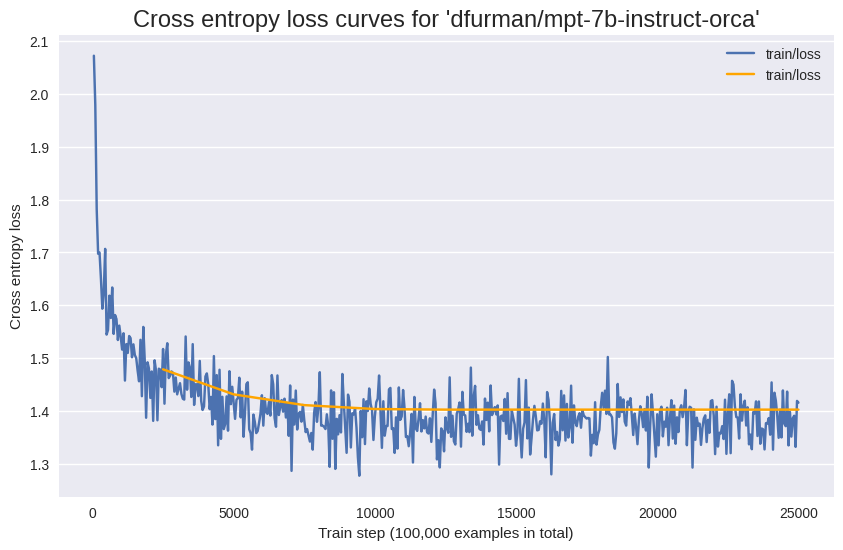

In [37]:
plt.style.use("seaborn")
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="train/loss")
plt.plot(val_steps, val_loss, label="train/loss", color="orange")
plt.title("Cross entropy loss curves for 'dfurman/mpt-7b-instruct-orca'", fontsize=17)
plt.ylabel("Cross entropy loss")
plt.xlabel("Train step (100,000 examples in total)")
plt.grid(which="major", axis="x")
plt.legend()
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [15]:
# load assets

# model_id = "./results/checkpoint-25000"
model_id = "dfurman/mpt-7b-instruct-orca"

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
config.attn_config[
    "attn_impl"
] = "triton"  # Optional triton attention for improved latency
config.init_device = "meta"  # For fast initialization directly on GPU!
# config.max_seq_len = 4096 # (input + output) tokens can now be up to 4096
config.torch_dtype = "bfloat16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

config

A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- configuration_mpt.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- meta_init_context.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- norm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- attention.py
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- param_init_fns.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- hf_prefixlm_converter.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- custom_embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- adapt_tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- blocks.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/mosaicml/mpt-7b:
- modeling_mpt.py
- meta_init_context.py
- norm.py
- attention.py
- param_init_fns.py
- hf_prefixlm_converter.py
- custom_embedding.py
- adapt_tokenizer.py
- blocks.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Instantiating an MPTForCausalLM model from /root/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/72e5f594ce36f9cabfa2a9fd8f58b491eb467ee7/modeling_mpt.py


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "dfurman/mpt-7b-instruct-orca",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "triton",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "meta",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_l

## Basic instruction tests

In [16]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Falcon model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate. Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.bfloat16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [30]:
prompt = "You are a helpful assistant. Write me a numbered list of things to do in New York City.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)

1. Visit the Statue of Liberty: The Statue of Liberty is a symbol of freedom and democracy, and it is a must-see attraction in New York City.
2. Take a walk in Central Park: Central Park is a massive green space in the heart of Manhattan, and it is a great place to relax, enjoy nature, and people-watch.
3. Visit the Metropolitan Museum of Art: The Met is one of the world's largest and most renowned art museums, housing an extensive collection of art from around the world.
4. Take a stroll through Times Square: Times Square is the heart of the city, and it is a must-see for its iconic billboards, bright lights, and bustling energy.
5. Visit the Empire State Building: The Empire State Building is a famous skyscraper in Midtown Manhattan, offering panoramic views of the city from its observation deck.
6. Explore the Museum of Modern Art (MoMA): MoMA is a renowned art museum in Midtown Manhattan, showcasing modern and contemporary art from around the world.
7. Visit the 9/11 Memorial and M

In [31]:
prompt = "You are a helpful assistant. Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense? Let's work this out in a step by step fashion to make sure we have the right answer.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)


Step 1: Identify the days of the week when the barber works.
The barber works on Mondays, Wednesdays, and Fridays.

Step 2: Determine the day of the week on which Daniel went for a haircut.
Daniel went for a haircut on Sunday.

Step 3: Compare the day of the week on which Daniel went for a haircut to the days when the barber works.
Sunday is not one of the days when the barber works.

Step 4: Determine if the statement makes logical sense.
The statement does not make logical sense because Daniel went for a haircut on a day when the barber does not work.

Answer: No, the statement does not make logical sense. Daniel should have gone for a haircut on a day when the barber works, such as Monday, Wednesday, or Friday.

In summary, the statement "Daniel went in for a haircut on Sunday" does not make logical sense because Sunday is not one of the days when the barber works. Daniel should have gone for a haircut on a day when the barber works, such as Monday, Wednesday, or Friday. Therefore,

In [32]:
prompt = "You are a helpful assistant. Write a short email inviting my friends to a dinner party on Friday. Respond succinctly.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=200,
    temperature=0.92,
)

print(response)

Subject: Invitation to Dinner Party on Friday

Dear Friend,

I hope this email finds you well. I am writing to invite you to a dinner party that I am hosting on Friday. The party will be a casual gathering, and I would love to have you join us.

The dinner will be held at my home, and the time is from 7:00 pm to 10:00 pm. The address is 123 Main Street, San Francisco, CA 94122.

The dinner will be a potluck, so please bring a dish to share. I will provide the main course, so you can focus on bringing a side dish, dessert, or appetizer.

Please RSVP by replying to this email or by calling me at 555-555-5555. I look forward to seeing you on Friday!

Yours,

Your Friendly Assistant

[Your name]

[Your email address]

[


In [36]:
prompt = "You are a helpful assistant. Here is a recipe for vegan banana bread:\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=150,
    temperature=0.92,
)

print(response)


- 1 cup mashed bananas
- 1/2 cup sugar
- 1/2 cup vegetable oil
- 1/2 cup soy milk
- 1/2 cup whole wheat flour
- 1/2 cup all-purpose flour
- 1 teaspoon baking soda
- 1/2 teaspoon salt
- 1/2 teaspoon cinnamon
- 1/2 teaspoon nutmeg
- 1/2 teaspoon vanilla extract
- 1/2 cup chopped walnuts

What is the first step of the recipe?
The first step of the recipe is to preheat the oven to 350°F (180°C) and prepare a 9x5-inch (23x13-cm) loaf pan by greasing it with


## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!git config --global credential.helper store

In [ ]:
# push to hub
model_id_load = "dfurman/mpt-7b-instruct-orca"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)

In [ ]:
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)